In [2]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import pandas as pd
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter


In [4]:
file_path = '/content/drive/MyDrive/Colab Notebooks/helpdesk_customer_tickets.csv'
df_en = pd.read_csv(file_path)

In [5]:
print(df_en.head())

    id                                            subject  \
0   36  Anfrage zu den Spezifikationen und Anpassungso...   
1   39               Déconnexions fréquentes et plantages   
2  243                        Problema de sonido Dell XPS   
3  381  Assistance requise pour la configuration du ta...   
4  663  Urgente: Assistência Imediata Necessária para ...   

                                                body  \
0  Sehr geehrtes Support-Team des Tech Online Sto...   
1  Le client signale des déconnexions fréquentes ...   
2  Problema con el sonido, manejando como devoluc...   
3  Cher support client,\n\nNotre client, <name>, ...   
4  Caro Suporte ao Cliente da Firma de Consultori...   

                                              answer      type  \
0  Sehr geehrter <name>,\n\nvielen Dank für Ihr I...   Request   
1  Nous allons enquêter sur le problème avec Zoom...  Incident   
2  Gracias por su correo electrónico. Procesaremo...   Problem   
3  Cher <name>,\n\nMerci de nous

In [42]:
nlp = spacy.load("en_core_web_sm")

In [43]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.lower()


In [44]:
df_en['subject_clean'] = df_en['subject'].apply(lambda x: clean_text(str(x)))
df_en['body_clean'] = df_en['body'].apply(lambda x: clean_text(str(x)))

In [45]:
def extract_nouns(text):
    doc = nlp(text)
    nouns = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN']]
    return nouns

In [19]:
df_en["nouns_subject"] = df_en["subject_clean"].apply(extract_nouns)
df_en["nouns_body"] = df_en["body_clean"].apply(extract_nouns)

In [20]:
print("Sample nouns extracted from subject:")
print(df_en["nouns_subject"].sample(n=3).values)


Sample nouns extracted from subject:
[list(['problemas', 'con', 'la', 'impresión', 'inalámbrica'])
 list(['serviceausfallproblem']) list(['issue', 'surface', 'touchscreen'])]


In [21]:
print("Sample nouns extracted from subject:")
print(df_en["nouns_subject"].sample(n=3).values)


Sample nouns extracted from subject:
[list(['assistance', 'microservice']) list(['problem', 'auf', 'surface'])
 list(['benötigt', 'bei', 'bildschirmflackern'])]


In [22]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df_en['subject_clean'] + " " + df_en['body_clean'])

In [23]:
num_clusters = 5  # Adjust the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_en['cluster'] = kmeans.fit_predict(X)

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(X.toarray())



In [25]:
x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
colors = ['r', 'b', 'g', 'c', 'm']

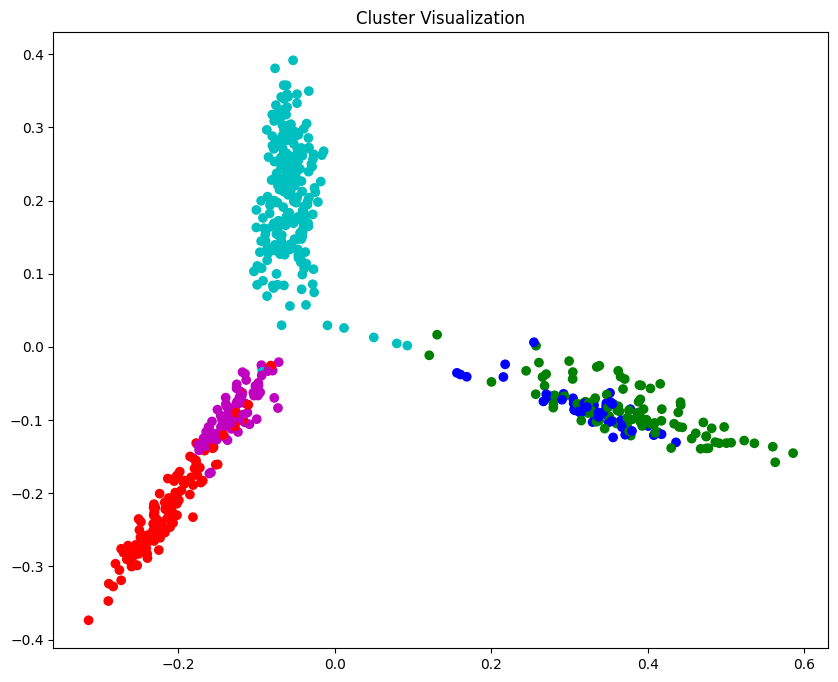

In [26]:
plt.figure(figsize=(10, 8))
plt.scatter(x_axis, y_axis, c=[colors[d] for d in df_en['cluster']])
plt.title("Cluster Visualization")
plt.show()

In [46]:
 #Tagging: Extract most common words from each cluster
def extract_tags(cluster_data, n=10):
    X_cluster = vectorizer.transform(cluster_data)
    words = vectorizer.get_feature_names_out()
    sum_words = X_cluster.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in zip(words, range(len(words)))]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return [word for word, freq in word_freq[:n]]

In [47]:
# Apply tag extraction for each cluster
for cluster in range(num_clusters):
    cluster_data = df_en[df_en['cluster'] == cluster]['subject_clean'] + df_en[df_en['cluster'] == cluster]['body_clean']
    tags = extract_tags(cluster_data)
    print(f"Cluster {cluster} Tags: {tags}")

Cluster 0 Tags: ['la', 'para', 'problema', 'mi', 'en', 'el', 'al', 'gracias', 'soporte', 'este']
Cluster 1 Tags: ['für', 'die', 'und', 'eine', 'wir', 'sie', 'mit', 'zu', 'bitte', 'um']
Cluster 2 Tags: ['ich', 'mit', 'der', 'sie', 'problem', 'habe', 'bitte', 'zu', 'bei', 'für']
Cluster 3 Tags: ['support', 'issue', 'thank', 'assistance', 'customer', 'problème', 'urgent', 'pour', 'experiencing', 'dell']
Cluster 4 Tags: ['com', 'problema', 'suporte', 'ao', 'para', 'obrigado', 'da', 'meu', 'estou', 'sua']


In [30]:
# Issue Detection: Identify main issues using POS tagging
df_en["issues"] = df_en["nouns_body"].apply(lambda x: " ".join(x))

In [31]:
tag_count = Counter([noun for nouns in df_en["nouns_body"] for noun in nouns])
total_tags = sum(tag_count.values())


In [32]:
tag_percentages = {tag: (count / total_tags) * 100 for tag, count in tag_count.items()}
print("Tag Occurrence Percentage:")
for tag, percentage in tag_percentages.items():
    print(f"{tag}: {percentage:.2f}%")

Tag Occurrence Percentage:
sehr: 0.69%
geehrtes: 0.04%
supportteam: 0.10%
tech: 0.59%
online: 0.09%
stores: 0.04%
ich: 1.00%
interessiere: 0.01%
mich: 0.23%
für: 0.47%
den: 0.15%
kauf: 0.02%
eines: 0.03%
macbook: 0.22%
air: 0.22%
m1: 0.22%
hätte: 0.02%
gerne: 0.02%
detaillierte: 0.03%
spezifikationen: 0.02%
sowie: 0.02%
informationen: 0.10%
zu: 0.55%
verfügbaren: 0.02%
anpassungsoptionen: 0.01%
könnten: 0.19%
sie: 0.82%
mir: 0.23%
bitte: 0.61%
diese: 0.09%
zur: 0.13%
verfügung: 0.03%
stellen: 0.04%
vielen: 0.30%
dank: 0.46%
ihre: 0.29%
unterstützung: 0.19%
mit: 0.65%
freundlichen: 0.37%
grüßen: 0.36%
name: 2.67%
le: 0.10%
client: 0.26%
signale: 0.01%
des: 0.39%
déconnexions: 0.01%
plantages: 0.01%
lors: 0.06%
réunions: 0.02%
vidéo: 0.01%
utilisant: 0.02%
zoom: 0.08%
veuillez: 0.13%
problema: 0.71%
con: 0.37%
el: 0.42%
sonido: 0.01%
manejando: 0.01%
como: 0.04%
días: 0.01%
cher: 0.27%
support: 0.93%
notre: 0.09%
pour: 0.29%
configurer: 0.01%
un: 0.57%
tableau: 0.01%
scrum: 0.05%
dans: 0

In [48]:
def extract_issue_details(text):
    doc = nlp(text)
    issues = []
    for token in doc:
        # Get nouns and verbs based on their dependencies and POS tags
        if token.dep_ in ('nsubj', 'dobj') and token.pos_ in ['NOUN', 'VERB']:
            issues.append(token.text)
    return issues

In [35]:
df_en["issues_details"] = df_en["body_clean"].apply(lambda x: extract_issue_details(x))

In [36]:
print("Sample extracted issues:")
print(df_en[["body_clean", "issues_details"]].sample(n=5))

Sample extracted issues:
                                            body_clean  \
38   prezado suporte ao cliente você poderia fornec...   
88   estimado equipo de soporte de servicios de ti ...   
529  sehr geehrter kunde des tech online shops ich ...   
141  hi i am experiencing issues with my canon pixm...   
14   sehr geehrte itservices unser dell xps 13 9310...   

                                        issues_details  
38                                    [buscando, name]  
88                       [dificultades, costos, antes]  
529  [shops, häufig, problem, schritte, reparatur, ...  
141                       [issues, printing, solution]  
14                    [geehrte, zu, lösen, name, dank]  


In [37]:
issue_count = Counter([issue for issues in df_en["issues_details"] for issue in issues])
total_issues = sum(issue_count.values())


In [38]:
issue_percentages = {issue: (count / total_issues) * 100 for issue, count in issue_count.items()}

In [39]:
# Display issue occurrence percentages
print("Issue Occurrence Percentage:")
for issue, percentage in issue_percentages.items():
    print(f"{issue}: {percentage:.2f}%")

Issue Occurrence Percentage:
geehrtes: 0.51%
name: 12.29%
veuillez: 0.05%
logiciel: 0.05%
está: 0.30%
support: 4.30%
issues: 2.02%
printer: 0.30%
assistance: 1.82%
issue: 4.35%
process: 0.25%
tel_num: 5.97%
customer: 0.35%
disconnections: 0.10%
zoom: 0.05%
server: 0.10%
system: 0.20%
downtime: 0.05%
operations: 0.51%
problem: 3.19%
functionality: 0.05%
request: 0.25%
team: 0.86%
monitor: 0.05%
drivers: 0.05%
persists: 0.10%
favor: 2.07%
erhebliche: 0.10%
geehrte: 0.10%
zu: 0.20%
lösen: 0.05%
dank: 0.05%
code: 0.56%
appareils: 0.05%
aide: 0.10%
status: 0.05%
project: 0.05%
adjustment: 0.10%
router: 0.05%
details: 0.51%
veces: 0.10%
responde: 0.30%
estos: 0.15%
gracias: 0.46%
einer: 0.15%
benötige: 0.35%
tickets: 0.25%
drops: 0.10%
productivity: 0.25%
company: 0.25%
times: 0.10%
connectivity: 0.10%
resolution: 0.56%
extensions: 0.05%
return: 0.15%
guidance: 0.40%
stores: 0.20%
tastatur: 0.10%
ticket: 0.20%
acontecer: 0.05%
por: 0.20%
aconselhe: 0.05%
capabilities: 0.05%
shops: 0.10%
prob

In [40]:
df_en["issue_summary"] = df_en["issues_details"].apply(lambda x: " ".join(x))


In [41]:
print("Final Data with Issue Summaries:")
print(df_en[['subject_clean', 'body_clean', 'issue_summary']].head())

Final Data with Issue Summaries:
                                       subject_clean  \
0  anfrage zu den spezifikationen und anpassungso...   
1               déconnexions fréquentes et plantages   
2                        problema de sonido dell xps   
3  assistance requise pour la configuration du ta...   
4  urgente assistência imediata necessária para f...   

                                          body_clean  issue_summary  
0  sehr geehrtes supportteam des tech online stor...  geehrtes name  
1  le client signale des déconnexions fréquentes ...       veuillez  
2  problema con el sonido manejando como devoluci...                 
3  cher support client notre client name a besoin...  name logiciel  
4  caro suporte ao cliente da firma de consultori...                 
